Kendall W über die Dimensionen


# =====================================================================
# 0. Setup: Pakete und Daten
# =====================================================================

In [10]:
# =====================================================================
# Pakete
# =====================================================================
library(dplyr)
library(tidyr)
library(ggplot2)
library(reshape2)
library(knitr)
library(irr)
library(readxl)

# =====================================================================
# 0. Daten einlesen
# =====================================================================
setwd("/Users/joern.ahlert/Desktop/Bachelorarbeit")

df_raw <- read_excel(
  path = "technische Umsetzung/Diagramme/Plausibilitätsbewertung von LLM Antworten2.xlsx"
)

# Beispiele:
# exclude_rows <- NULL        # Keine Zeile weglassen
# exclude_rows <- 3           # Nur Zeile 3 weglassen
# exclude_rows <- c(1, 5, 7)  # Zeilen 1, 5 und 7 weglassen

exclude_rows <- NULL  # <- HIER EINGEBEN, welche Zeile(n) weggelassen werden sollen

# Zeilen entfernen, falls angegeben
if (!is.null(exclude_rows)) {
  cat("Weglassen von Zeile(n):", exclude_rows, "\n")
  cat("Anzahl Zeilen vorher:", nrow(df_raw), "\n")
  df_raw <- df_raw[-exclude_rows, ]
  cat("Anzahl Zeilen nachher:", nrow(df_raw), "\n\n")
} else {
  cat("Keine Zeilen werden weggelassen.\n\n")
}


View(df_raw)
# =====================================================================
# 1. Antworttexte in numerische Scores umkodieren
# =====================================================================
likert_map <- c(
  "Trifft überhaupt nicht zu" = 1,
  "Trifft eher nicht zu"      = 2,
  "Trifft teilweise zu"       = 3,
  "Trifft eher zu"            = 4,
  "Trifft voll und ganz zu"   = 5
)

plaus_map <- c(
  "Unmöglich – Die Antwort widerspricht der Logik oder dem Kontext vollständig" = 1,
  "Technisch möglich – Theoretisch denkbar, aber extrem unwahrscheinlich"      = 2,
  "Plausibel – Könnte zutreffen, ist aber nicht der Normalfall"                = 3,
  "Wahrscheinlich – Klingt vernünftig und entspricht der Erwartung"            = 4,
  "Sehr wahrscheinlich – Sehr überzeugend; so würde ein Experte antworten"     = 5
)


meta_cols <- c("ID", "Startzeit", "Fertigstellungszeit",
               "E-Mail", "Name", "Zeitpunkt der letzten Änderung")
item_cols <- setdiff(names(df_raw), meta_cols)

plaus_cols   <- grep("Wie plausibel ist die Antwort", item_cols, value = TRUE)
quality_cols <- setdiff(item_cols, plaus_cols)

df_num <- df_raw |>
  mutate(
    across(all_of(quality_cols), ~ likert_map[.x]),
    across(all_of(plaus_cols),   ~ plaus_map[.x])
  )

# =====================================================================
# 2. Items Fragen und Dimensionen zuordnen
# =====================================================================
n_fragen <- 8
n_items_pro_frage <- length(item_cols) / n_fragen

frage_nr <- rep(1:n_fragen, each = n_items_pro_frage)

item_info <- data.frame(
  Spalte   = item_cols,
  Frage_Nr = frage_nr
)

item_info <- item_info |>
  mutate(
    Dimension = case_when(
      grepl("relevanten Informationen aus dem Kontext", Spalte) ~ "Kontextverständnis",
      grepl("korrektes Verständnis des Kontexts", Spalte)       ~ "Kontextverständnis",
      grepl("statt allgemeinem Wissen", Spalte)                 ~ "Kontextverständnis",
      
      grepl("widersprechen sich nicht", Spalte)                 ~ "Kohärenz",
      grepl("Schlussfolgerungen in der Antwort", Spalte)        ~ "Kohärenz",
      grepl("Gedankenführung der Antwort", Spalte)              ~ "Kohärenz",
      
      grepl("Detailtiefe der Antwort", Spalte)                  ~ "Angemessenheit",
      grepl("adressiert alle wesentlichen Aspekte", Spalte)     ~ "Angemessenheit",
      
      grepl("Wie plausibel ist die Antwort", Spalte)            ~ "Gesamtplausibilität",
      TRUE ~ NA_character_
    )
  )

# =====================================================================
# 3. Long-Format bauen
# =====================================================================
df_long <- df_num |>
  mutate(Episode = row_number()) |>
  pivot_longer(
    cols      = all_of(item_cols),
    names_to  = "Spalte",
    values_to = "Score"
  ) |>
  left_join(item_info, by = "Spalte")

# =====================================================================
# 4. Aggregation ins LLM-Format
# =====================================================================
df <- df_long |>
  group_by(Episode, Frage_Nr, Dimension) |>
  summarise(Score = mean(Score, na.rm = TRUE), .groups = "drop") |>
  pivot_wider(
    names_from  = Dimension,
    values_from = Score
  ) |>
  rename(
    Kontextverständnis_Score  = Kontextverständnis,
    Kohärenz_Score            = Kohärenz,
    Angemessenheit_Score      = Angemessenheit,
    Gesamtplausibilität_Score = Gesamtplausibilität
  ) |>
  arrange(Episode, Frage_Nr)

View(df)


Keine Zeilen werden weggelassen.



ID,Startzeit,Fertigstellungszeit,E-Mail,Name,Zeitpunkt der letzten Änderung,Die Antwort erfasst die relevanten Informationen aus dem Kontext.,Die Antwort zeigt ein korrektes Verständnis des Kontexts.,Die Antwort nutzt relevante Informationen aus dem gegebenen Kontext zur Beantwortung der Frage (statt allgemeinem Wissen).,Die Aussagen in der Antwort widersprechen sich nicht.,⋯,"Wie plausibel ist die Antwort, basierend auf dem gegebenen Kontext?7",Die Antwort erfasst die relevanten Informationen aus dem Kontext.8,Die Antwort zeigt ein korrektes Verständnis des Kontexts.8,Die Antwort nutzt relevante Informationen aus dem gegebenen Kontext zur Beantwortung der Frage (statt allgemeinem Wissen).7,Die Aussagen in der Antwort widersprechen sich nicht.8,Die Schlussfolgerungen in der Antwort ergeben sich logisch aus den Gründen/Prämissen.8,Die Gedankenführung der Antwort ist klar und gut zu folgen.9,"Die Detailtiefe der Antwort ist passend zur Fragestellung – nicht zu oberflächlich, nicht zu ausschweifend.8",Die Antwort adressiert alle wesentlichen Aspekte der Frage – es fehlen keine wichtigen Informationen.8,"Wie plausibel ist die Antwort, basierend auf dem gegebenen Kontext?8"
<dbl>,<dttm>,<dttm>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
4,2025-12-09 18:32:40,2025-12-09 19:36:22,anonymous,NA,NA,Trifft voll und ganz zu,Trifft voll und ganz zu,Trifft überhaupt nicht zu,Trifft eher zu,⋯,"Plausibel – Könnte zutreffen, ist aber nicht der Normalfall",Trifft teilweise zu,Trifft teilweise zu,Trifft eher nicht zu,Trifft überhaupt nicht zu,Trifft teilweise zu,Trifft eher nicht zu,Trifft teilweise zu,Trifft teilweise zu,"Plausibel – Könnte zutreffen, ist aber nicht der Normalfall"
5,2025-12-11 10:43:43,2025-12-11 10:53:23,anonymous,NA,NA,Trifft eher zu,Trifft eher zu,Trifft eher zu,Trifft eher zu,⋯,"Plausibel – Könnte zutreffen, ist aber nicht der Normalfall",Trifft voll und ganz zu,Trifft voll und ganz zu,Trifft voll und ganz zu,Trifft voll und ganz zu,Trifft voll und ganz zu,Trifft voll und ganz zu,Trifft voll und ganz zu,Trifft voll und ganz zu,Wahrscheinlich – Klingt vernünftig und entspricht der Erwartung
6,2025-12-14 20:33:59,2025-12-15 22:14:01,anonymous,NA,NA,Trifft teilweise zu,Trifft eher zu,Trifft eher nicht zu,Trifft voll und ganz zu,⋯,Wahrscheinlich – Klingt vernünftig und entspricht der Erwartung,Trifft teilweise zu,Trifft eher zu,Trifft eher nicht zu,Trifft eher zu,Trifft teilweise zu,Trifft teilweise zu,Trifft eher zu,Trifft eher zu,"Plausibel – Könnte zutreffen, ist aber nicht der Normalfall"
7,2025-12-17 14:35:27,2025-12-17 14:55:00,anonymous,NA,NA,Trifft voll und ganz zu,Trifft teilweise zu,Trifft überhaupt nicht zu,Trifft voll und ganz zu,⋯,Sehr wahrscheinlich – Sehr überzeugend; so würde ein Experte antworten,Trifft teilweise zu,Trifft teilweise zu,Trifft teilweise zu,Trifft eher zu,Trifft eher zu,Trifft eher zu,Trifft eher zu,Trifft eher zu,"Plausibel – Könnte zutreffen, ist aber nicht der Normalfall"
8,2025-12-17 14:44:04,2025-12-17 15:10:55,anonymous,NA,NA,Trifft voll und ganz zu,Trifft voll und ganz zu,Trifft teilweise zu,Trifft voll und ganz zu,⋯,Wahrscheinlich – Klingt vernünftig und entspricht der Erwartung,Trifft eher zu,Trifft voll und ganz zu,Trifft teilweise zu,Trifft teilweise zu,Trifft teilweise zu,Trifft eher nicht zu,Trifft eher zu,Trifft teilweise zu,"Technisch möglich – Theoretisch denkbar, aber extrem unwahrscheinlich"
9,2025-12-17 16:01:47,2025-12-17 16:19:21,anonymous,NA,NA,Trifft eher nicht zu,Kann ich nicht beantworten,Trifft überhaupt nicht zu,Trifft voll und ganz zu,⋯,Wahrscheinlich – Klingt vernünftig und entspricht der Erwartung,Kann ich nicht beantworten,Kann ich nicht beantworten,Trifft eher nicht zu,Trifft voll und ganz zu,Trifft voll und ganz zu,Trifft voll und ganz zu,Trifft eher zu,Trifft teilweise zu,"Plausibel – Könnte zutreffen, ist aber nicht der Normalfall"
10,2025-12-17 17:03:13,2025-12-17 17:52:34,anonymous,NA,NA,Trifft voll 

Episode,Frage_Nr,Angemessenheit_Score,Gesamtplausibilität_Score,Kohärenz_Score,Kontextverständnis_Score
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,4.0,4,4.333333,3.666667
1,2,1.0,3,1.666667,2.000000
1,3,4.0,4,5.000000,4.666667
1,4,5.0,4,4.250000,4.500000
1,5,4.0,2,2.333333,3.666667
1,6,4.0,2,2.000000,3.333333
1,7,4.0,3,3.000000,3.000000
1,8,3.0,3,2.000000,2.666667
2,1,5.0,4,4.000000,4.000000


# =====================================================================
# 1. Deskriptive Statistik – dimensionsspezifisch
# =====================================================================


In [11]:
metriken <- c("Kontextverständnis_Score",
              "Kohärenz_Score",
              "Angemessenheit_Score",
              "Gesamtplausibilität_Score")

deskriptiv_dim <- data.frame(
  Dimension = c("Kontextverständnis",
                "Kohärenz",
                "Angemessenheit",
                "Plausibilität nach Zhang"),
  Min = sapply(df[metriken], min,  na.rm = TRUE),
  Max = sapply(df[metriken], max,  na.rm = TRUE),
  M   = sapply(df[metriken], mean, na.rm = TRUE),
  SD  = sapply(df[metriken], sd,   na.rm = TRUE)
)

kable(deskriptiv_dim, digits = 2,
      caption = "Deskriptive Statistik der LLM-Scores über 100 Iterationen (dimensionsspezifisch).")




Table: Deskriptive Statistik der LLM-Scores über 100 Iterationen (dimensionsspezifisch).

|                          |Dimension                |  Min| Max|    M|   SD|
|:-------------------------|:------------------------|----:|---:|----:|----:|
|Kontextverständnis_Score  |Kontextverständnis       | 1.50|   5| 3.68| 0.95|
|Kohärenz_Score            |Kohärenz                 | 1.67|   5| 3.84| 1.03|
|Angemessenheit_Score      |Angemessenheit           | 1.00|   5| 3.87| 0.98|
|Gesamtplausibilität_Score |Plausibilität nach Zhang | 1.00|   5| 3.41| 0.96|

# Boxplot der vier Dimensionen

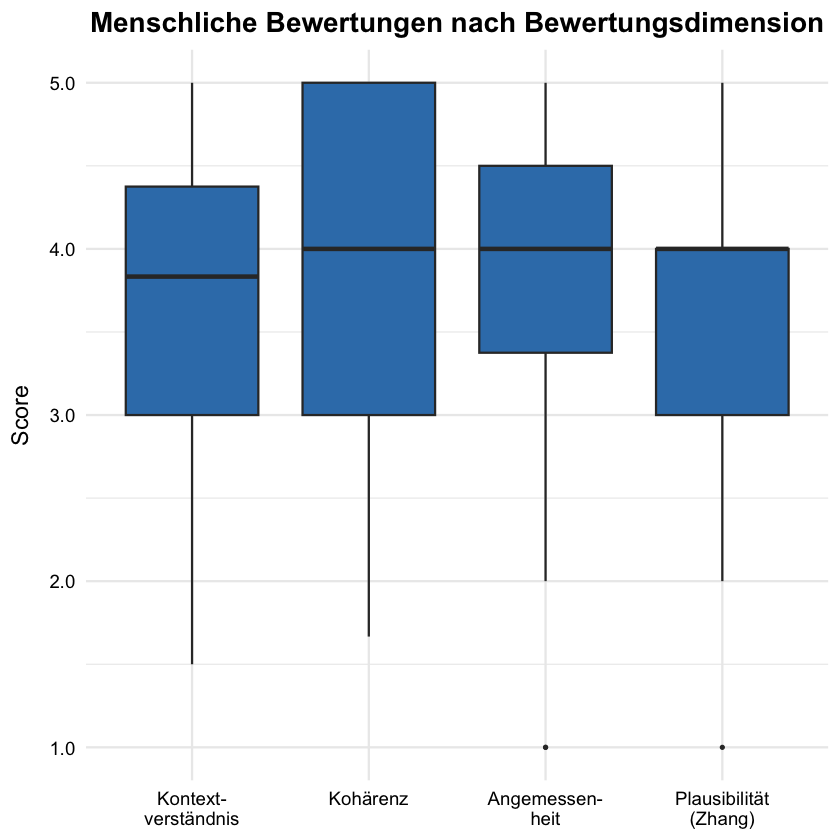

In [12]:
library(ggplot2)
library(scales)

df_long <- df |>
  select(Frage_Nr, all_of(metriken)) |>
  pivot_longer(
    cols = all_of(metriken),
    names_to = "Dimension",
    values_to = "Score"
  ) |>
  mutate(
    Dimension = factor(
      Dimension,
      levels = metriken,
      labels = c(
        "Kontextverständnis",
        "Kohärenz",
        "Angemessenheit",
        "Plausibilität nach Zhang"
      )
    )
  )

ggplot(df_long, aes(x = Dimension, y = Score)) +
  geom_boxplot(fill = "#377eb8", outlier.size = 0.8) +
  labs(
    title = "Menschliche Bewertungen nach Bewertungsdimension",
    x = NULL,
    y = "Score"
  ) +
  scale_x_discrete(
    labels = c(
      "Kontext-\nverständnis",
      "Kohärenz",
      "Angemessen-\nheit",
      "Plausibilität\n(Zhang)"
    )
  ) +
  scale_y_continuous(
    n.breaks = 6,
    labels = number_format(accuracy = 0.1)
  ) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title   = element_text(face = "bold", hjust = 0.5),
    axis.text.x  = element_text(angle = 0, vjust = 1, hjust = 0.5),
    axis.title.y = element_text(margin = margin(r = 10)),
    axis.text    = element_text(color = "black")
  )



# =====================================================================
# 2. Deskriptive Statistik – aggregierter gewichteter Score
# =====================================================================

In [13]:
# Aggregierter gewichteter Score (Kontextverständnis 30%, Kohärenz 40%, Angemessenheit 30%)
df$Aggregierter_Score <- 0.3 * df$Kontextverständnis_Score +
                        0.4 * df$Kohärenz_Score +
                        0.3 * df$Angemessenheit_Score

# Deskriptive Statistik für den aggregierten Score
aggregiert_stats <- data.frame(
  Min        = min(df$Aggregierter_Score, na.rm = TRUE),
  Max        = max(df$Aggregierter_Score, na.rm = TRUE),
  Mittelwert = mean(df$Aggregierter_Score, na.rm = TRUE),
  SD         = sd(df$Aggregierter_Score, na.rm = TRUE)
)

kable(aggregiert_stats, digits = 2,
      caption = "Deskriptive Statistik des aggregierten Scores (gewichteter Mittelwert über die drei Dimensionen).")



Table: Deskriptive Statistik des aggregierten Scores (gewichteter Mittelwert über die drei Dimensionen).

|  Min| Max| Mittelwert|  SD|
|----:|---:|----------:|---:|
| 1.57|   5|        3.8| 0.8|


# Boxplot des aggregierten Scores

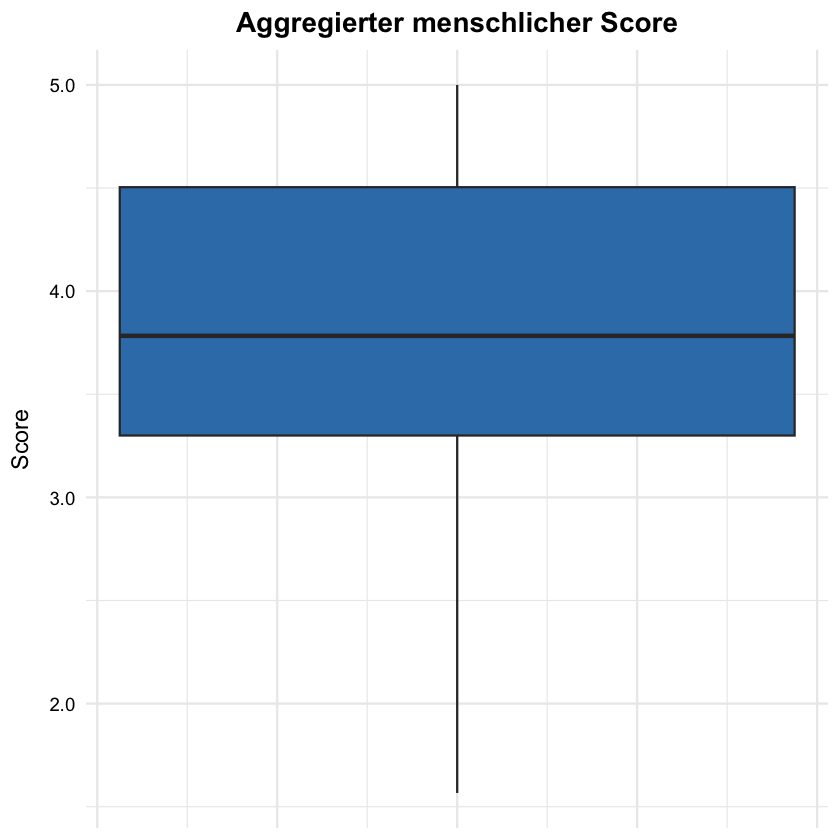

In [17]:
ggplot(df, aes(y = Aggregierter_Score)) +
  geom_boxplot(fill = "#377eb8", outlier.size = 0.8) +
  labs(
    title = "Aggregierter menschlicher Score",
    y = "Score",
    x = NULL
  ) +
  scale_y_continuous(
    n.breaks = 6,
    labels = number_format(accuracy = 0.1)
  ) +
  theme_minimal(base_size = 14) +
  theme(
    axis.title.x = element_blank(),
    axis.text.x  = element_blank(),
    axis.ticks.x = element_blank(),
    plot.title   = element_text(face = "bold", hjust = 0.5),
    axis.title.y = element_text(margin = margin(r = 10)),
    axis.text    = element_text(color = "black")
  )


# =====================================================================
# 3. Intra-Rater-Reliabilität – Kendall's W pro Dimension
# =====================================================================

In [15]:
metriken <- c("Kontextverständnis_Score",
              "Kohärenz_Score",
              "Angemessenheit_Score",
              "Gesamtplausibilität_Score")

kendall_w_dim <- sapply(metriken, function(metric) {
  mat <- dcast(df, Frage_Nr ~ Episode, value.var = metric)
  mat <- mat[, -1]  # Frage_Nr entfernen
  kendall(mat)$value
})

m      <- 100  # Iterationen (Rater)
n      <- 8    # Fragen (Items)
df_chi <- n - 1

chi2_values <- m * (n - 1) * kendall_w_dim
p_values    <- 1 - pchisq(chi2_values, df = df_chi)

results_dim <- data.frame(
  Dimension = c("Kontextverständnis",
                "Kohärenz",
                "Angemessenheit",
                "Plausibilität nach Zhang"),
  W   = round(kendall_w_dim, 4),
  p   = p_values
)

# P-Werte schöner darstellen (z.B. "< 0.001" statt "3.13e-09")
results_dim$p_formatted <- ifelse(results_dim$p < 0.001, "< 0.001",
                                  ifelse(results_dim$p < 0.01, "< 0.01",
                                         ifelse(results_dim$p < 0.05, "< 0.05", 
                                                round(results_dim$p, 3))))

results_dim$Signifikanz <- ifelse(results_dim$p < 0.001, "***",
                           ifelse(results_dim$p < 0.01, "**",
                           ifelse(results_dim$p < 0.05, "*", "n.s.")))

kable(results_dim[, c("Dimension", "W", "p_formatted", "Signifikanz")], digits = 3,
      caption = "Intra-Rater-Reliabilität des LLM-Judges nach Dimension (Kendall's $W$).")



Table: Intra-Rater-Reliabilität des LLM-Judges nach Dimension (Kendall's $W$).

|                          |Dimension                |     W|p_formatted |Signifikanz |
|:-------------------------|:------------------------|-----:|:-----------|:-----------|
|Kontextverständnis_Score  |Kontextverständnis       | 0.119|< 0.001     |***         |
|Kohärenz_Score            |Kohärenz                 | 0.262|< 0.001     |***         |
|Angemessenheit_Score      |Angemessenheit           | 0.166|< 0.001     |***         |
|Gesamtplausibilität_Score |Plausibilität nach Zhang | 0.146|< 0.001     |***         |

# =====================================================================
# 4. Intra-Rater-Reliabilität – Kendall's W aggregiert
# =====================================================================

In [16]:
# Aggregierter Score: Kendall's W, Chi2, p-Wert und Signifikanz

# Matrix: Zeilen = Fragen (Items), Spalten = Episoden (Rater)
mat_agg <- dcast(df, Frage_Nr ~ Episode, value.var = "Aggregierter_Score")
mat_agg <- mat_agg[, -1]  # Frage_Nr entfernen

# Kendall's W berechnen
kendall_w_agg <- kendall(mat_agg)$value

m      <- 100  # Iterationen (Rater)
n      <- 8    # Fragen (Items)
df_chi <- n - 1

chi2_agg <- m * (n - 1) * kendall_w_agg
p_agg    <- 1 - pchisq(chi2_agg, df = df_chi)

# Ergebnis-Dataframe wie bei den Dimensionen
results_agg <- data.frame(
  Score = "Aggregierter Score",
  W   = round(kendall_w_agg, 4),
  p   = p_agg
)

# P-Wert schöner darstellen
results_agg$p_formatted <- ifelse(results_agg$p < 0.001, "< 0.001",
                                  ifelse(results_agg$p < 0.01, "< 0.01",
                                         ifelse(results_agg$p < 0.05, "< 0.05", 
                                                round(results_agg$p, 3))))

results_agg$Signifikanz <- ifelse(results_agg$p < 0.001, "***",
                            ifelse(results_agg$p < 0.01, "**",
                            ifelse(results_agg$p < 0.05, "*", "n.s.")))

kable(results_agg[, c("Score", "W", "p_formatted", "Signifikanz")], digits = 3,
      caption = "Intra-Rater-Reliabilität des LLM-Judges für den aggregierten Score (Kendall's $W$).")



Table: Intra-Rater-Reliabilität des LLM-Judges für den aggregierten Score (Kendall's $W$).

|Score              |     W|p_formatted |Signifikanz |
|:------------------|-----:|:-----------|:-----------|
|Aggregierter Score | 0.164|< 0.001     |***         |